In [1]:
import os
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import welch
from mne.time_frequency import psd_array_multitaper
import seaborn as sns

import HD_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Section 1: check theat oscillation of example recording session


In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        theta = np.array(sdata['theta']).flatten()
        thetatimes = np.array(sdata['thetatimes']).flatten()
        eeg = np.array(sdata['eeg']).flatten()
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])
        f0 = np.array(light1['F0'])
        sintcptFreqy = np.array(light1['sintcptFreqy'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])
            intrinsic_freq = np.array(sdata[cell_name][part_now]['intrinsic_theta_frequency'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'intrinsic_freq': intrinsic_freq,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'f0': f0,
            'sintcptFreqy': sintcptFreqy,
            'cell_names': cell_names,
            'cells_data': cells_data,
            'theta': theta,
            'thetatimes': thetatimes,
            'eeg': eeg
        }

        return data_dict



In [3]:
def plot_theta(theta, thetatimes, eeg, T=1000):
    '''
    plot filtered theta from LFP signal
    '''
    fig, axs = plt.subplots(3,1, figsize=(5,5), dpi=300)
    
    ax = axs[0]
    ax.plot(thetatimes[:T], eeg[:T], color='black', linewidth=0.5, alpha=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('EEG filtered')
    ax.set_title('Raw - EEG')
    
    ax = axs[1]
    ax.plot(thetatimes[:T], theta[:T], color='black', linewidth=0.5, alpha=0.5)
    phase = HD_utils.get_phase(theta[:T])
    axs[1].scatter(thetatimes[:T][phase<0.5], theta[:T][phase<0.5], color='red', s=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Theta')
    ax.set_title('Bandpass Filtered - Theta') 
    
    ax = axs[2]
    # Compute the power spectrum using Welch's method, frequency is 250 Hz
    frequencies, power_spectrum = welch(eeg, fs=250)
    # Plot the power spectrum
    axs[2].semilogy(frequencies, power_spectrum,color='deepskyblue')  # Plot on a log scale for better visibility
    axs[2].set_xlim(0, 50)  # Adjust x-axis limits to focus on lower frequencies
    axs[2].set_ylim(bottom=1e-3)  # Adjust y-axis limits to avoid taking the log of zero

    axs[2].set_xlabel('Frequency (Hz)')
    axs[2].set_ylabel(r'Power Density [$V^2$/Hz]')
    axs[2].set_title('Power Spectrum of the Signal')

    # Highlight the theta frequency band
    theta_range = (6, 12)  # Theta band (Hz)
    axs[2].fill_between(frequencies, power_spectrum, where=(frequencies >= theta_range[0]) & (frequencies <= theta_range[1]), color='orange', alpha=0.5)

    axs[2].grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)   
    
    
    plt.tight_layout()  
    

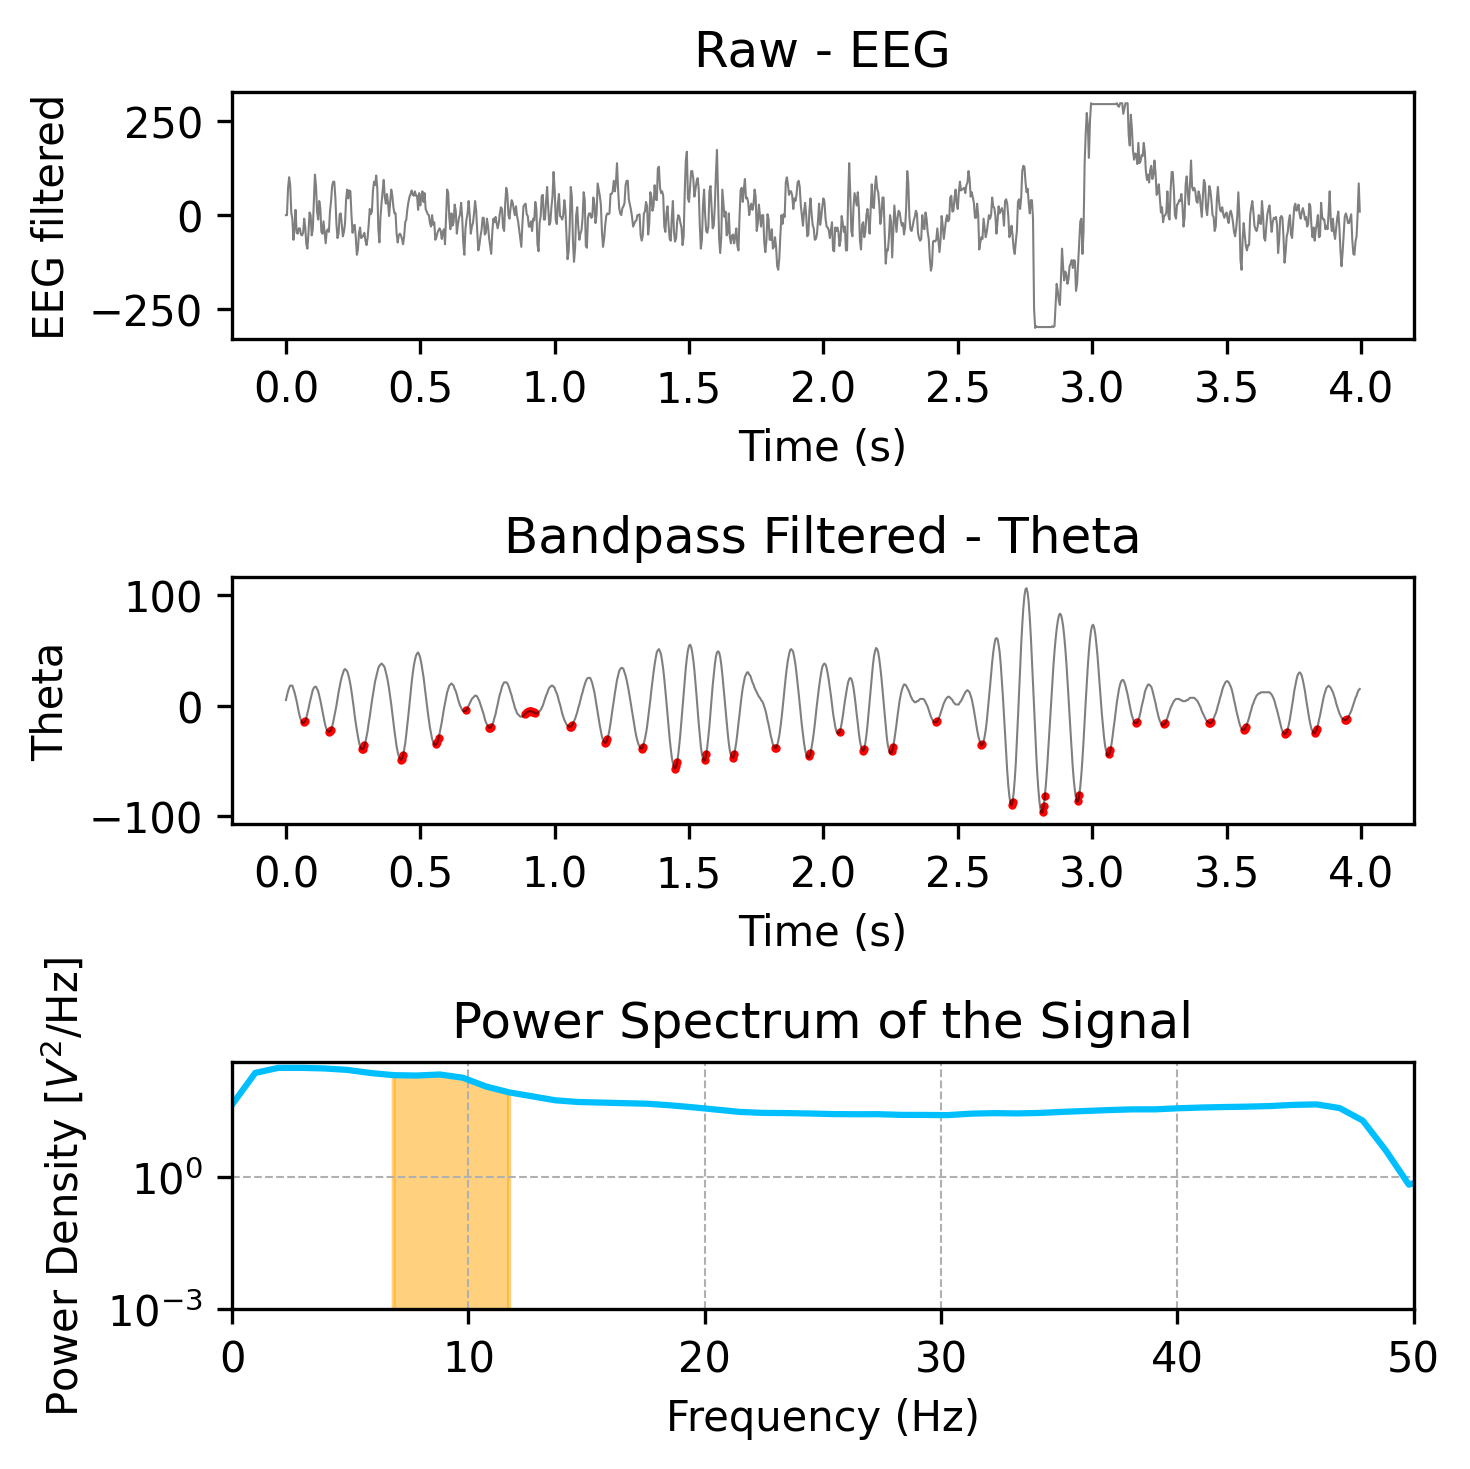

In [4]:
ratname='R449'
file_path='/home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r449/R449_02042020_T1_sdata.mat'
data_dict = load_data(ratname, file_path)
plot_theta(data_dict['theta'], data_dict['thetatimes'], data_dict['eeg'], T=1000)

## Section 2: get intrinsic frequency of an example neuron

In [5]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    theta_times = data_dict['thetatimes']
                    lfp_theta = data_dict['theta']                
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        matnames[cell_name] = [ratname, file_path]

Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhas

500.0


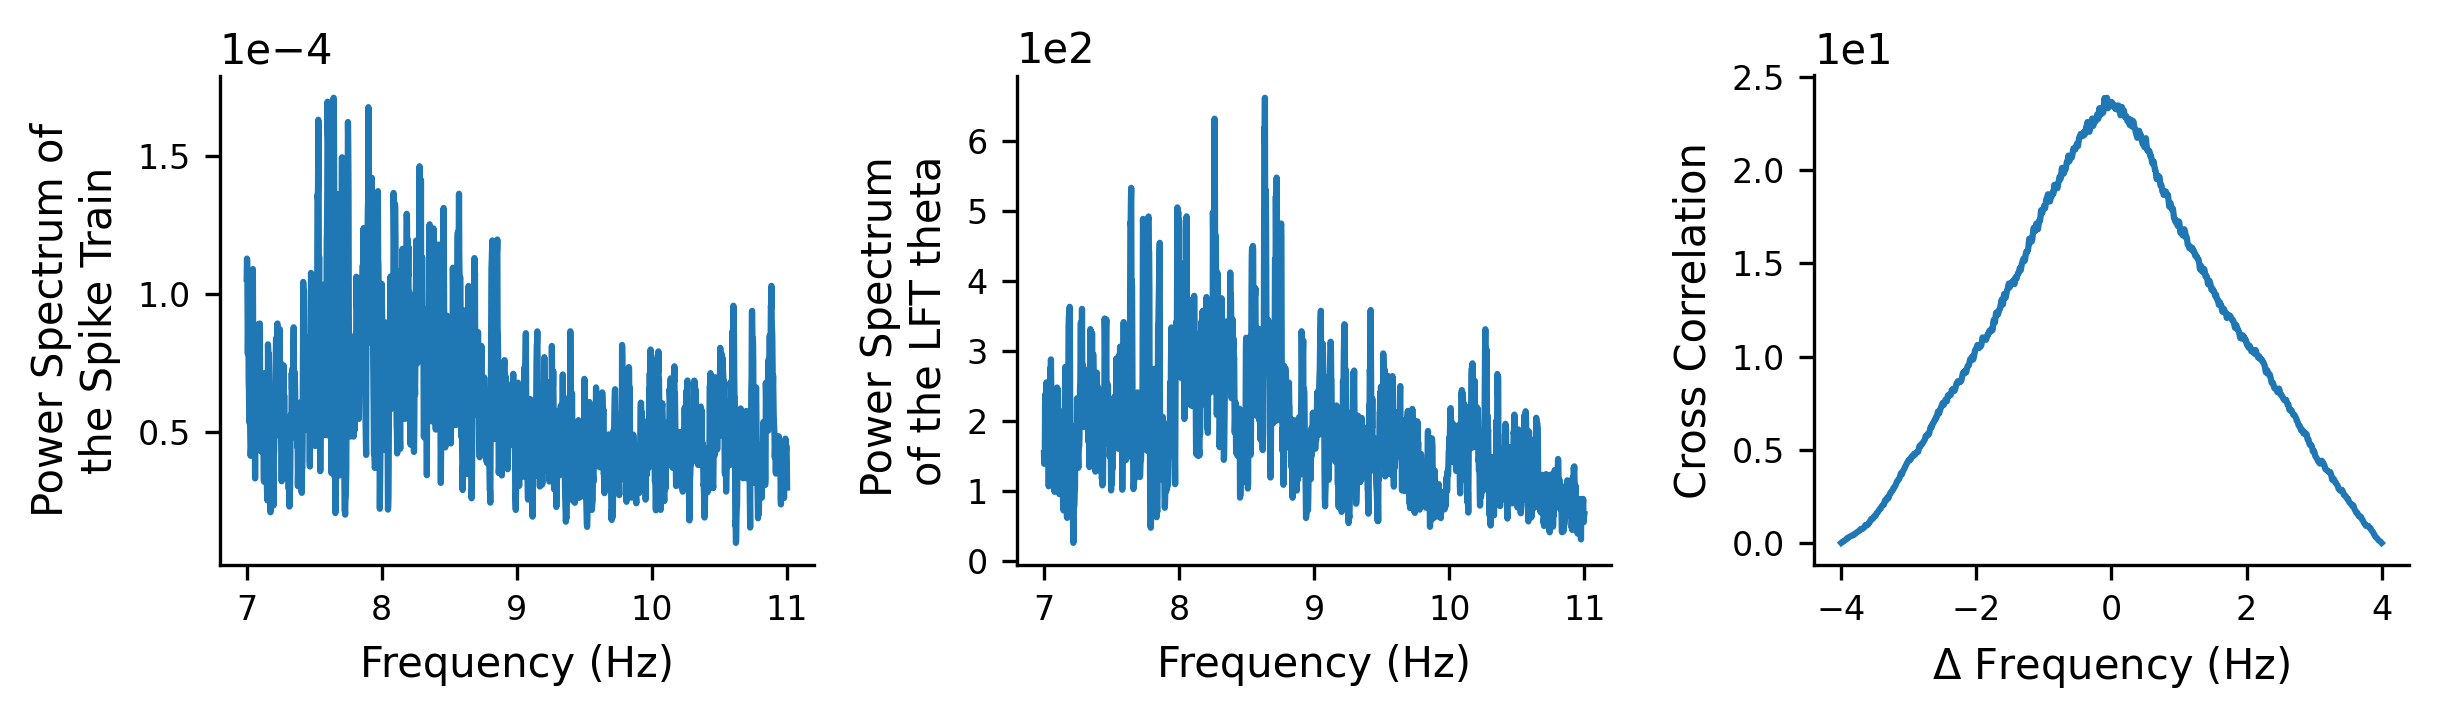

In [16]:
cell_name = 'rR762_01022019_t2_c1' #  'rR651_26062019_t1_c1'
ratname, file_path = matnames[cell_name]
data_dict = load_data(ratname, file_path)

rotation_only = True

#calculate the power spectrum of a spike train for a cell using direct multi-taper method
cell_name = data_dict['cell_names'][0]


spiketimes = data_dict['cells_data'][cell_name]['pspt'].flatten() #spike time

if rotation_only is True:  #further filter the spike train by rotation periods
    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
        'speed_threshold': 0.5,
        'duration_threshold': 0.5,
        'speed_smooth_sigma': 2, 
        'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
        'interpolation_factor': 2 #1 is 0.02s, and 2 is 0.01s
    }
    poh = data_dict['poh'].flatten()
    pot = data_dict['pot'].flatten()
    spiketimes = HD_utils.get_rotation_spiketimes(poh, pot, spiketimes, config)


spikearray = HD_utils.compute_spike_array(spiketimes, data_dict['thetatimes'])
print(np.sum(spikearray))


fig, axs = plt.subplots(1,3, figsize=(8.3,2.5), dpi=300)

psd_cell, freqs_cell = psd_array_multitaper(spikearray, sfreq=250, fmin=7, fmax=11, adaptive=True, remove_dc=True, normalization='full', verbose=False)
ax = axs[0]
# Plot the power spectrum
ax.plot(freqs_cell, psd_cell)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectrum of\nthe Spike Train')

psd_theta, freqs_theta = psd_array_multitaper(data_dict['theta'], sfreq=250, fmin=7, fmax=11, adaptive=True, remove_dc=True, normalization='full', verbose=False)
ax = axs[1]
# Plot the power spectrum
ax.plot(freqs_theta, psd_theta)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectrum \nof the LFT theta')

# Cross-correlation between psd_cell and psd_theta by shifting psd_theta
ax = axs[2]
# n_shift = len(freqs_theta)
# corr = np.zeros(2 * n_shift + 1)  # Array to hold correlation values

# # Perform shifts to the left and right
# for i in range(-n_shift, n_shift + 1):
#     shifted_psd_theta = np.roll(psd_theta, i)
#     corr[i + n_shift] = np.corrcoef(psd_cell, shifted_psd_theta)[0, 1]

# # Create a new frequency axis for plotting the correlation
# shifted_freqs = np.arange(-n_shift, n_shift + 1) * (freqs_theta[1] - freqs_theta[0])

corr = np.correlate(psd_cell, psd_theta, mode='full')
lags = np.arange(-len(psd_theta)+1, len(psd_theta)) * (freqs_theta[1] - freqs_theta[0])

# Plot the cross-correlation
# ax.plot(shifted_freqs, corr)
ax.plot(lags, corr)
ax.set_xlabel(r'$\Delta$ Frequency (Hz)')
ax.set_ylabel('Cross Correlation')


for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #y tick labels in scientific notation
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    #tick size as 8
    ax.tick_params(axis='both', which='major', labelsize=8)
    #label size as 10
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)
    #title size as 10
    ax.set_title(ax.get_title(), fontsize=10)
    
plt.tight_layout()

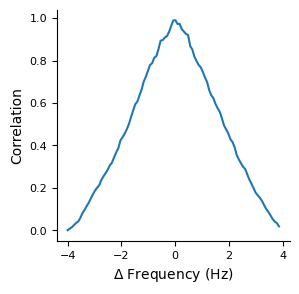

In [14]:
#calculate the power spectrum of a spike train for a cell using direct multi-taper method
cell_name = data_dict['cell_names'][0]
spiketimes = data_dict['cells_data'][cell_name]['pspt'].flatten() #spike time
spikearray = HD_utils.compute_spike_array(spiketimes, data_dict['thetatimes'])

shifted_freqs, corr = HD_utils.compute_cross_correlation(spikearray, data_dict['eeg'], sfreq=250, fmin=7, fmax=11)
#plot the cross-correlation
plt.figure(figsize=(3,3), dpi=100)
plt.plot(shifted_freqs, corr)
plt.xlabel(r'$\Delta$ Frequency (Hz)', fontsize=10)
plt.ylabel('Correlation', fontsize=10)
#tickszie as 8
plt.tick_params(axis='both', which='major', labelsize=8)
sns.despine()


## Section 3: corss correlation of all cells

In [17]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

rotation_only = True

IntrinsicFreq_Results = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    theta_times = data_dict['thetatimes']
                    lfp_theta = data_dict['theta']                
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']  
                        pval = cell_data['pval'][0][0]  
                        
                        #calculate cross-correlation between spike phase and theta
                        spiketimes = cell_data['pspt'].flatten()
                        
                        if rotation_only is True:  #further filter the spike train by rotation periods
                            print('filtering by rotation periods')
                            # Configuration
                            config = {
                                'speed_threshold': 0.5,
                                'duration_threshold': 0.5,
                                'speed_smooth_sigma': 2, 
                            }
                            poh = data_dict['poh'].flatten()
                            pot = data_dict['pot'].flatten()
                            spiketimes = HD_utils.get_rotation_spiketimes(poh, pot, spiketimes, config)
                        
                        spikearray = HD_utils.compute_spike_array(spiketimes, theta_times)
                        lags, corr = HD_utils.compute_cross_correlation(spikearray, lfp_theta, sfreq=250, fmin=7, fmax=11)
                        # print(corr.shape)
                        
                        #save cell type, intrinsic frequency, and cross-correlation to the dictionary with key name as cell_name
                        IntrinsicFreq_Results[cell_name] = {
                            'cell_type': cell_type,
                            'intrinsic_freq': intrinsic_freq,
                            'cross_correlation': corr,
                            'lags': lags,
                            'pval': pval
                        }

Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
filtering by rotation periods
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
filtering by rotation periods
filtering by rotation periods
filtering by rotation periods
filtering by rotation periods
filtering by rotation periods
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
filtering by rotation periods
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
filtering by rotation periods
filtering by rotation periods
filtering by rotation periods
filtering by rotation periods
filtering by rotation periods
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r

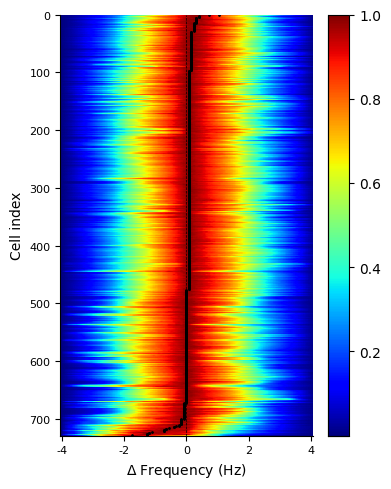

In [30]:
#extract all corr in the dictionary
corrs = [result['cross_correlation'] for result in IntrinsicFreq_Results.values()]
#extract all lags in the dictionary
lags = IntrinsicFreq_Results[list(IntrinsicFreq_Results.keys())[0]]['lags']
#extract all intrinsic_freq in the dictionary\
intrinsic_freqs = [result['intrinsic_freq'] for result in IntrinsicFreq_Results.values()]
#extract cell types
cell_types = [result['cell_type'] for result in IntrinsicFreq_Results.values()]

#copy the corrs to a new list and Smooth each corr using a Gaussian filter with a standard deviation of 5
# corrs = [gaussian_filter1d(corr, 5) for corr in corrs]

#get the index of max value in each corr
max_idx = [np.argmax(corr) for corr in corrs]
#rank the max value in descending order
ranked_idx = np.argsort(max_idx)[::-1]
#rank them
max_idx_ranked = [max_idx[idx] for idx in ranked_idx]
intrinsic_freqs_ranked = [intrinsic_freqs[idx] for idx in ranked_idx]
cell_types_ranked = [cell_types[idx] for idx in ranked_idx]

ranked_corrs = [corrs[idx] for idx in ranked_idx]
#convert to numpy array
ranked_corrs = np.array(ranked_corrs)
#plot ranked_corr as a heatmap using colormap 'jet'

fig, ax = plt.subplots(1,1, figsize=(4,5), dpi=100)

plotCells = ranked_corrs.shape[0]

ranked_corrs = ranked_corrs[:plotCells, :]

im = ax.imshow(ranked_corrs, cmap='jet', aspect='auto')
plt.colorbar(im)

#add vertical line at half of x axis
ax.axvline(x=len(lags)//2, color='black', linestyle='--', linewidth=0.5)

#plot the max_idx as a scatter plot on the heatmap
for i, idx in enumerate(max_idx_ranked):
    if i < plotCells:
        ax.scatter(idx, i, color='black', s=1)
    else:
        break

#set x ticks at 0, 50, 100 as -7 0 7

ax.set_xticks([0, len(lags)//4, len(lags)//2, 3*len(lags)//4, len(lags)-1])
ax.set_xticklabels([-4, -2, 0, 2, 4])

sns.despine()
#ticksize as 8
plt.tick_params(axis='both', which='major', labelsize=8)

ax.set_xlabel(r'$\Delta$ Frequency (Hz)', fontsize=10)
ax.set_ylabel('Cell index', fontsize=10)

plt.tight_layout()


Text(0, 0.5, 'Intrinsic Frequency (Hz)')

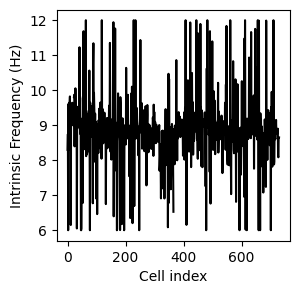

In [ ]:
#plot intrinsic_freqs_ranked calculated by Lomi
plt.figure(figsize=(3,3), dpi=100)
plt.plot(intrinsic_freqs_ranked, color='black')
plt.xlabel('Cell index', fontsize=10)
plt.ylabel('Intrinsic Frequency (Hz)', fontsize=10)

In [ ]:
#extract all corr in the dictionary
corrs = [result['cross_correlation'] for result in IntrinsicFreq_Results.values()]
#extract all lags in the dictionary
lags = IntrinsicFreq_Results[list(IntrinsicFreq_Results.keys())[0]]['lags']
#extract all intrinsic_freq in the dictionary\
intrinsic_freqs = [result['intrinsic_freq'] for result in IntrinsicFreq_Results.values()]
#extract cell types
cell_types = [result['cell_type'] for result in IntrinsicFreq_Results.values()]
#extract pval
pvals = [result['pval'] for result in IntrinsicFreq_Results.values()]

#now get the index with the cell_type contains both key words 'ThetaxHD' and 'skip'
skipcorr = []
nonskipcorr = []
for i, ct in enumerate(cell_types):
    pval = pvals[i]
    if pval > 0.05:
        continue
    if 'ThetaxHD' in ct and 'skip' in ct:
        #select the corr
        skipcorr.append(corrs[i])
    # elif 'ThetaxHD' not in ct and 'skip' not in ct:
    elif 'HDC' in ct:
        nonskipcorr.append(corrs[i])


#plot the skipcorr as a heatmap using colormap 'jet'

fig, axs = plt.subplots(1,2, figsize=(8,5), dpi=100)

ax = axs[0]
#get the index of max value in each corr
max_idx = [np.argmax(corr) for corr in skipcorr]
#rank skipcorr by max_idx
ranked_idx = np.argsort(max_idx)[::-1]
#rank them
skipcorr_ranked = [skipcorr[idx] for idx in ranked_idx]
max_idx_ranked = [max_idx[idx] for idx in ranked_idx]
#to array
skipcorr_ranked = np.array(skipcorr_ranked)
#plot ranked_corr as a heatmap using colormap 'jet'
im = ax.imshow(skipcorr_ranked, cmap='jet', aspect='auto')

#vertical
ax.axvline(x=len(lags)//2, color='white', linestyle='--', linewidth=0.5)

ax = axs[1]
#get the index of max value in each corr
max_idx = [np.argmax(corr) for corr in nonskipcorr]
#rank skipcorr by max_idx
ranked_idx = np.argsort(max_idx)[::-1]
#rank them
nonskipcorr_ranked = [nonskipcorr[idx] for idx in ranked_idx]
max_idx_ranked = [max_idx[idx] for idx in ranked_idx]
#to array
nonskipcorr_ranked = np.array(nonskipcorr_ranked)
#plot ranked_corr as a heatmap using colormap 'jet'
im = ax.imshow(nonskipcorr_ranked, cmap='jet', aspect='auto')

#vertical
ax.axvline(x=len(lags)//2, color='white', linestyle='--', linewidth=0.5)



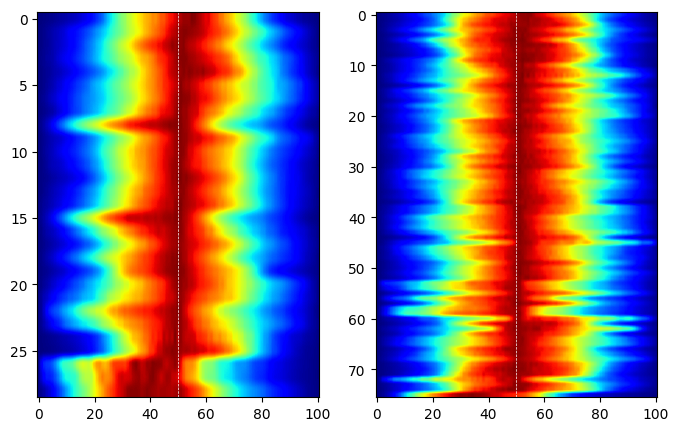

In [42]:
#extract all corr in the dictionary
corrs = [result['cross_correlation'] for result in IntrinsicFreq_Results.values()]
#extract all lags in the dictionary
lags = IntrinsicFreq_Results[list(IntrinsicFreq_Results.keys())[0]]['lags']
#extract all intrinsic_freq in the dictionary\
intrinsic_freqs = [result['intrinsic_freq'] for result in IntrinsicFreq_Results.values()]
#extract cell types
cell_types = [result['cell_type'] for result in IntrinsicFreq_Results.values()]
#extract pval
pvals = [result['pval'] for result in IntrinsicFreq_Results.values()]

#now get the index with the cell_type contains both key words 'ThetaxHD' and 'skip'
skipcorr = []
nonskipcorr = []
for i, ct in enumerate(cell_types):
    pval = pvals[i]
    if pval > 0.05:
        continue
    if 'ThetaxHD' in ct and 'skip' in ct:
        #select the corr
        skipcorr.append(corrs[i])
    # elif 'ThetaxHD' not in ct and 'skip' not in ct:
    elif 'HDC' in ct:
        nonskipcorr.append(corrs[i])


#plot the skipcorr as a heatmap using colormap 'jet'

fig, axs = plt.subplots(1,2, figsize=(8,5), dpi=100)

ax = axs[0]
#get the index of max value in each corr
max_idx = [np.argmax(corr) for corr in skipcorr]
#rank skipcorr by max_idx
ranked_idx = np.argsort(max_idx)[::-1]
#rank them
skipcorr_ranked = [skipcorr[idx] for idx in ranked_idx]
max_idx_ranked = [max_idx[idx] for idx in ranked_idx]
#to array
skipcorr_ranked = np.array(skipcorr_ranked)
#plot ranked_corr as a heatmap using colormap 'jet'
im = ax.imshow(skipcorr_ranked, cmap='jet', aspect='auto')

#vertical
ax.axvline(x=len(lags)//2, color='white', linestyle='--', linewidth=0.5)

ax = axs[1]
#get the index of max value in each corr
max_idx = [np.argmax(corr) for corr in nonskipcorr]
#rank skipcorr by max_idx
ranked_idx = np.argsort(max_idx)[::-1]
#rank them
nonskipcorr_ranked = [nonskipcorr[idx] for idx in ranked_idx]
max_idx_ranked = [max_idx[idx] for idx in ranked_idx]
#to array
nonskipcorr_ranked = np.array(nonskipcorr_ranked)
#plot ranked_corr as a heatmap using colormap 'jet'
im = ax.imshow(nonskipcorr_ranked, cmap='jet', aspect='auto')

#vertical
ax.axvline(x=len(lags)//2, color='white', linestyle='--', linewidth=0.5)


## subselect the spike time by choosing those continuous rotation periods